<a href="https://colab.research.google.com/github/Karimby1/CMR_stage/blob/less_than_10/less_than_10_Light.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 📦 Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import lightgbm as lgb


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# 🔽 Lire ton fichier CSV
df = pd.read_csv('/content/drive/MyDrive/cmrcleann.csv', delimiter=';')

# 🎯 Garder uniquement les produits dont le prix unitaire < 10 €
df_low10 = df[df['UnitCostToEuro'] < 10].copy()


In [ ]:
# 🔁 Convertir en datetime
df_low10['DatePhysical'] = pd.to_datetime(df_low10['DatePhysical'], dayfirst=True)

# Extraire les composantes temporelles
df_low10['Year'] = df_low10['DatePhysical'].dt.year
df_low10['Month'] = df_low10['DatePhysical'].dt.month
df_low10['Quarter'] = df_low10['DatePhysical'].dt.quarter
df_low10['IsEndOfYear'] = df_low10['Month'].isin([11, 12]).astype(int)


In [ ]:
# 🔢 LightGBM accepte les 'category', mais pas 'object'
for col in ['Product', 'Company', 'RRS_Purchase', 'RRS_Sales']:
    df_low10[col] = df_low10[col].astype('category')


In [ ]:
# 🎯 Sélection des features
features = [
    'Product', 'Company', 'RRS_Purchase', 'RRS_Sales',
    'QTY', 'MoisAchat', 'Year', 'Month', 'Quarter', 'IsEndOfYear'
]

X = df_low10[features]
y = df_low10['UnitCostToEuro']

# ➗ Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
# 🧠 Entraîner LightGBM
model = lgb.LGBMRegressor(random_state=42)
model.fit(X_train, y_train)


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7135
[LightGBM] [Info] Number of data points in the train set: 138565, number of used features: 10
[LightGBM] [Info] Start training from score 2.150592


LGBMRegressor(random_state=42)

In [ ]:
# 🔍 Prédictions
y_pred = model.predict(X_test)

# 📊 Évaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)


# 📢 Affichage des résultats
print(f"✅ MAE  : {mae:.4f} €")
print(f"✅ RMSE : {rmse:.4f} €")
print(f"✅ R²   : {r2:.4f}")



✅ MAE  : 0.6984 €
✅ RMSE : 1.3241 €
✅ R²   : 0.7425


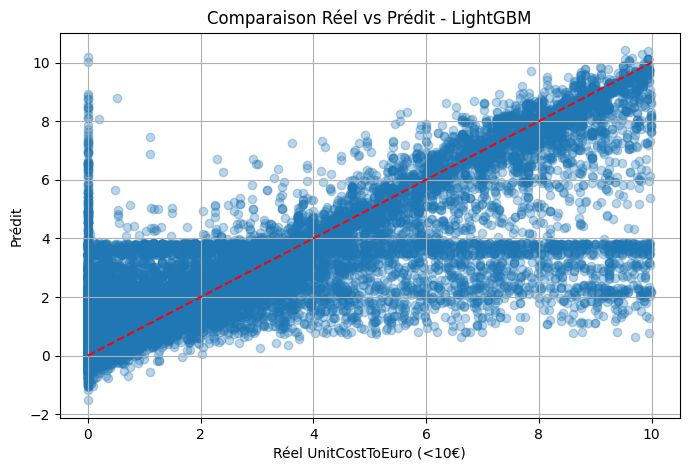

In [ ]:
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Réel UnitCostToEuro (<10€)")
plt.ylabel("Prédit")
plt.title("Comparaison Réel vs Prédit - LightGBM")
plt.grid()
plt.show()
